# Gaussian Processes and infinite Neural Nets

Gaussian Processes (GPs) generalize the Gaussian distributions to situations where the random variable can be regarded as a function. As such, they are a powerful tool for regression and Bayesian inference. In the last years they have received increased attention with the renewed interest in machine learning. I found one connection particularly interesting. At a seminar, I once heard that Gaussian processes could be regarded as infinite Neural Networks. I always wondered about this connection, and so I want to explore it in this article. 

## Introduction

Before we get started, we need to introduce GPs and motivate their use. To do so, we start with a short introduction of multivariate Gaussians and conditional Gaussians as we will make heavy use of them. Readers familiar with the topic may want to skip the introduction.

### Multinomial Gaussian distributions

We introduce the multivariate Gaussian distribution, which is defined as

$$\mathcal{N}(x | \mu, \Sigma) = \frac{1}{\sqrt{ (2 \pi)^d |\Sigma|}} \exp \left\{ - \frac{1}{2} (x - \mu)^T \, \Sigma^{-1} \, (x - \mu)\right\}.$$

The parameters of the distribution are the mean $\mu \in \mathbb{R}^d$ and the covariance matrix $\Sigma \in \mathbb{R}^{d \times d}$. We can restrict our analysis to symmetric positive definite matrices $\Sigma$, as the antisymmetric part of $\Sigma$ does not contribute to the quadric form in the exponent.

In Julia, we can make use of the `Distributions` package to define our multivariate Gaussian:

In [277]:
using Random, Distributions, LinearAlgebra
Random.seed!(123) # this sets the random seed to 123, so that our code becomes reproducible
using Plots # for plotting
theme(:vibrant)

In [278]:
d = 2
μ = Random.randn(d)
X = Random.randn(d, d)
Σ = X'*X

dist = MvNormal(μ, Σ)

FullNormal(
dim: 2
μ: [1.1902678809862768, 2.04817970778924]
Σ: [1.5167137980972474 -0.7586450344468244; -0.7586450344468244 0.5991970596857172]
)


We can visualize the resulting distribution and sample from it. Here, the syntax `(x,y)->Distributions.pdf(dist,[x,y])` extracts the PDF of the distribution in its functional form.

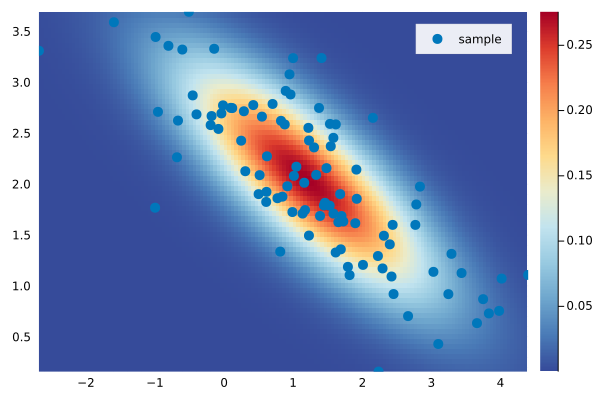

In [279]:
n = 100
x = rand(dist, n)

xmin = min(x[1,:]...)
xmax = max(x[1,:]...)
ymin = min(x[2,:]...)
ymax = max(x[2,:]...)

heatmap(xmin:0.05:xmax, ymin:0.05:ymax, (x,y)->Distributions.pdf(dist,[x,y]))
scatter!(x[1,:], x[2,:], label="sample", xlims = (xmin, xmax), ylims = (ymin, ymax))

### Conditional Gaussians

Let us discuss conditional distributions. We stick to the common practice of distinguishing between random variables denoted by capital letters and their actual realizations denoted by lowercase letters. Assume $X \sim \mathcal{N}(x | \mu, \Sigma)$, where we have observed the first $k$ components $x_1, x_2, \dots, x_k$ of $X$. We are interested in knowing the conditional contribution $p(x_{k+1}, \dots, x_d | x_1, \dots, x_k)$ for the remaining, unobserved variables. For this purpose, let us partition the covariance matrix and the mean according to the variables:

$$
x = \begin{bmatrix}
    x_a \\
    x_b
    \end{bmatrix},
\qquad
\mu = \begin{bmatrix}
    \mu_a \\
    \mu_b
    \end{bmatrix},
\qquad
\Sigma = \begin{bmatrix}
    \Sigma_{aa} & \Sigma_{ab} \\
    \Sigma_{ba} & \Sigma_{bb}
    \end{bmatrix}.
$$

Here, the subscript $a$ corresponds to the first $k$ entries, which are the observed entries, whereas $b$ corresponds to the remaining $d-k$ entries. One can show that the conditional distribution $p(x_{k+1}, \dots, x_d | x_1, \dots, x_k) = p(x_b | x_a)$ is a multinomial Gaussian itself, i.e. 

$$
p(x_b | x_a) = \mathcal{N}(x_b | \bar{\mu}, \bar{\Sigma}),
$$

where $\bar{\mu}, \bar{\Sigma}$ are the parameters of the conditional distribution. By inserting the partitioned variables and re-shuffling the terms in the exponent, we find that $\bar{mu}$ is determined by the conditioned mean

$$
\bar{\mu} = \mu_b + \Sigma_{ba} \Sigma_{aa}^{-1} (x_a - \mu_a)
$$

and conditioned co-variance matrix

$$
\bar{\Sigma} = \Sigma_{bb} - \Sigma_{ba} \Sigma_{aa}^{-1} \Sigma_{ab}.
$$

The attentive reader may recognise this as the Schur complement, which appears when the blocked covariance matrix $\Sigma$ is factored and the degrees of freedom corresponding to $a$ are factored out.

## Gaussian Processes as generalizations of Gaussian distributions

Now that we have seen how the Gaussian distribution is generalized to $d$ dmensions, we may ask: "What if the random variable was a function?" This is where Gaussian Processes come in.

### Definition

An example of a Kernel function is the radial-basis function (RBF) kernel

$$
K(x,x') = \exp \left\{ - \frac{1}{2\sigma^2} ||x - x'||^2\right\},
$$

where $\sigma$ is some parameter controlling the width of the kernel. Due to Julia's functional nature, defining the RBF kernel is straight-forward:

In [473]:
K(xa, xb; σ=1.) = exp.(- [norm(a).^2 for a in (xa .- xb)] ./ (2.0 * σ^2)) # RBF kernel

K (generic function with 2 methods)

Let us visualize the kernel function:

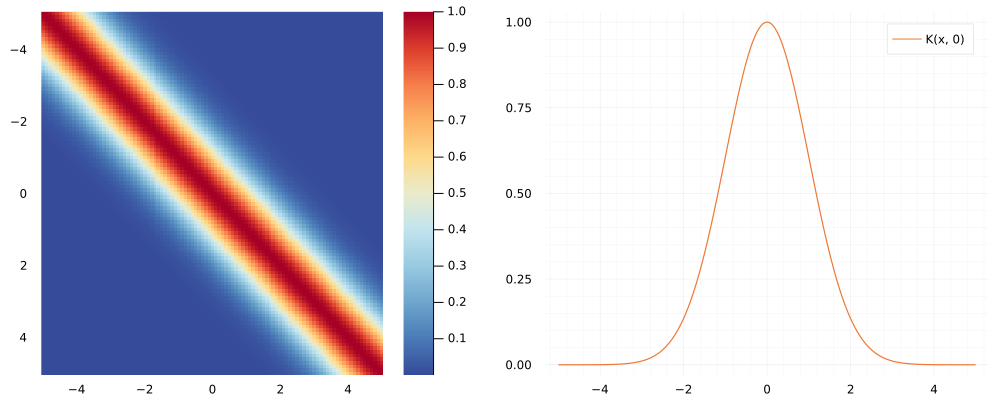

In [474]:
plot1 = heatmap(-5:0.1:5, -5:0.1:5, K, yflip = true)

xa = collect(-5:0.05:5)
xb = zero(xa)
plot2 = plot(xa, K(xa, xb), label="K(x, 0)")

plot(plot1, plot2, layout = @layout([a{1.0h} b]), size=(1000,400))

The figure on the right illustrates the kernel function $K(0, x')$. 

What does this mean? Let us illustrate some realizations of this GP, i.e.

$$
f(x) \sim GP(m(x), K(x,x')).
$$

To do so, we pick $n$ points on the real axis $x = (x_1, x_2, \dots, x_n)^T$ and observe $f(x_i)$ at these points. To simplify this, we set $m(x) = 0$ which implies that all we need to do is to sample $n$ observations from the multivariate Gaussian $\mathcal{N}(0, S)$, where the covariance matrix is given by $S_{ij} = K(x_i, x_j)$.

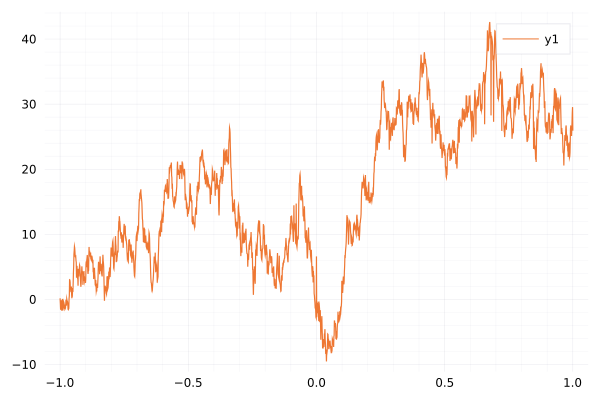

In [475]:
# currently, we require a little workaround as the Distributions.jl package is very much tied to the idea that covariance
# matrices should be positive definite. To avoid this issue, we make use of the package PDMatsExtras, which defines the 
# PSDMat type which is a type for positive semi-definite matrices
using PDMatsExtras

mesh = -1:0.001:1

S = [K(xa,xb) for xa in mesh, xb in mesh]
#I = [xa == xb for xa in mesh, xb in mesh]
GP = MvNormal(zero(mesh), PSDMat(S)) # this is the workaround

# sampling the distribution gives us divverent instance of the random variable f
samples = rand(GP,1)
plot(mesh,samples)

## Connection to Neural Networks

[![Illustration of single layer articial neural network](./images/single_layer_ann.svg)](https://en.wikipedia.org/wiki/Artificial_neural_network)

Illustration of a feed-forward neural network (source: https://en.wikipedia.org/wiki/Artificial_neural_network).